## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️


# How to Evaluate Machine Learning Models: Choosing Performance Metrics

In this Jupyter Notebook, we will explore various performance metrics for evaluating machine learning models. The choice of an evaluation metric is crucial and often depends on the problem being solved. A clear understanding of a wide range of metrics can help identify an appropriate match between the problem statement and a metric.

We will (again) work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).

<a name='import'></a>
## Import Packages

- `sklearn` is one of the most popular machine learning libraries.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [ ]:
!pip install pydotplus
!pip install lifelines

In [2]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

<a name='1'></a>
## 1. The Dataset
### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?

With **pandas**, we usually can explore some key properties very rapidly, for instance with commands like

- `data.head()`
- `data.describe()`
- `data.info()`

### Some weird conventions:
For some reason it became standard in the machine learning world to name the actual data `X` and the labels `y`. Even though I consider this a rather poor choice both from a math and from a code best practice point of view, we will stick to this in this notebook.

In [3]:
path_data = "../data/"

X = pd.read_csv("NHANESI_subset_X.csv")
y = pd.read_csv("NHANESI_subset_y.csv")

X = X.drop('Unnamed: 0', axis=1)
y = y.drop('Unnamed: 0', axis=1)

X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


Remove missing values with `dropna`.

In [4]:
data = X.copy()
data["time"] = y
data = data.dropna(axis="rows")
data.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,time
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,15.274658
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,11.586073
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,8.149087
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,-21.094292
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,-0.000000


## Convert the label

The original label (the column `time`) is not easy to understand. And it is not a very good goal for a machine learning model. We therefore convert it into a boolean which is True if a person died within 10 years and False if a person survived at least 10 years.

In [5]:
period = 10  # time period we consider --> we focus on >10 year risk

def died_in_period(time, period):
    # Option 1: Person died within period
    if time > 0 and time < period:
        return 1

    # Option 2: Person left study before period ended --> no conclusion possible
    if time <= 0 and time > -period:
        return np.nan

    # Option 3 + 4: Person left study after >= period or survived >= period
    return 0
    
death_in_period = np.array([died_in_period(time, period) for time in data.time])
death_in_period

array([0., 0., 1., ..., 0., 0., 0.], shape=(8593,))

In [6]:
data["death_in_period"] = death_in_period

# Remove missing entries
data = data.dropna()

data.death_in_period.value_counts()

death_in_period
0.0    6954
1.0    1279
Name: count, dtype: int64

In [7]:
# Create data/label split --> X, y
X = data.drop(["death_in_period", "time"], axis='columns')
y = data["death_in_period"]

In [8]:
X.shape, y.shape

((8233, 18), (8233,))

## Split data --> Train (70%) + Val (15%) + Test (15%)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=10)

In [10]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                  test_size=0.5, random_state=10)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((5763, 18), (1235, 18), (1235, 18))

In [12]:
# in this context we will also use the c-index to evaluate our models
import lifelines

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

<a name='2'></a>
## 2. Random Forests

Over the last weeks we learned that **random forests**, which combine predictions from many different trees, function as a much more a robust classifier when compared to individual trees. They have a much lower risk of overfitting, and they generally show better prediction performance. 

But even with a **grid search** and a **random search** we were hardly able to get better results than before. Let's see if we can do a little better. Or, where we still have issues we need to fix.

In [13]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=5,
                                min_samples_leaf=5,
                                random_state=10)
# train the model
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=10)

In [14]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.8819126975832668
Val C-Index: 0.8517954960438223


In [15]:
# compute the accuracy (fraction of correct predictions)
y_predictions = forest.predict(X_val)

(y_predictions == y_val).sum() / y_val.shape[0]

np.float64(0.8340080971659919)

### Question 1: Is this good? OK-ish? Or bad?

### Question 2: How many people would receive the diagnoses "< 10 years survival" from our model?
(on the validation set)

In [16]:
y_predictions.sum()

np.float64(9.0)

In [17]:
from sklearn.metrics import confusion_matrix

In [19]:
conf_matrix =confusion_matrix(y_val, y_predictions)

---
## 4. Model evaluation metrics
### Confusion matrix
The confusion matrix looks like this (considering 1 -Positive and 0 -Negative as the target classes):

|             | Actual 0             | Actual 1             |
| ----------- | -------------------- | -------------------- |
| Predicted 0 | True Negatives (TN)  | False Negatives (FN) |
| Predicted 1 | False Positives (FP) | True Positives (TP)  |

- TN: Number of negative cases correctly classified
- TP: Number of positive cases correctly classified
- FN: Number of positive cases incorrectly classified as negative
- FP: Number of negative cases incorrectly classified as positive

## Metrics in Scikit-Learn

Scikit-Learn comes with many metrics in its `metrics` module. For instance:
- `metrics.confusion_matrix`
- `metrics.accuracy_score`
- `metrics.precision_score`
- `metrics.recall_score`
- `metrics.f1_score`
- `metrics.classification_report`

In [26]:
def plot_confusion_matrix(confusion_matrix):
    """ Simple plot of a confusion matrix using Seaborn's heatmap."""
    plt.figure(figsize=(6, 4), dpi=100)
    sb.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16},
               cmap="Purples",
               fmt="g")

    # Set labels and title
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)

    # Show the plot
    plt.show()

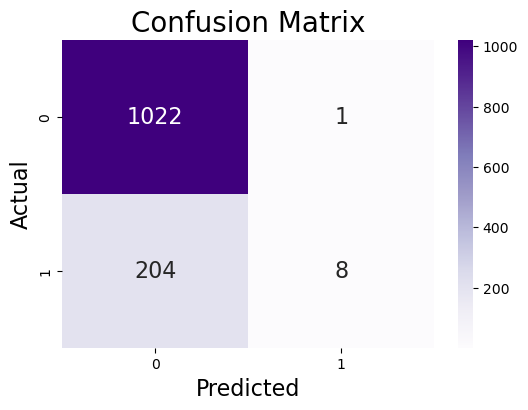

In [27]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(conf_matrix)
# TODO: Compute confusion matrix

### Accuracy
Accuracy is the simplest metric and can be defined as the number of test cases correctly classified divided by the total number of test cases. It can be applied to most generic problems but is not very useful when it comes to unbalanced datasets.

For instance, if we are detecting frauds in bank data, the ratio of fraud to non-fraud cases can be 1:99. In such cases, if accuracy is used, the model will turn out to be 99% accurate by predicting all test cases as non-fraud. The 99% accurate model will be completely useless.

Therefore, for such a case, a metric is required that can focus on the ten fraud data points which were completely missed by the model.

In [29]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_val, y_predictions)
print(accuracy)

0.8340080971659919


In [39]:
y_predictions_dummy = np.zeros(y_val.shape[0])

In [40]:
accuracy = metrics.accuracy_score(y_val, y_predictions_dummy)
print(accuracy)

0.8283400809716599


### Alternative evaluation metric: concordance

We can also use concordance, or the C-Index for evaluation.

The C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).

More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:

$$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$



### Precision
Precision is the metric used to identify the correctness of classification. Intuitively, this equation is the ratio of correct positive classifications to the total number of predicted positive classifications. The greater the fraction, the higher is the precision, which means better is the ability of the model to correctly classify the positive class.

$$P = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

In the problem of predictive maintenance (where one must predict in advance when a machine needs to be repaired), precision comes into play. The cost of maintenance is usually high, and thus, incorrect predictions can lead to a loss for the company. In such cases, the ability of the model to correctly classify the positive class and to lower the number of false positives is paramount!

In [31]:
precision = metrics.precision_score(y_val,y_predictions)
print(precision)

0.8888888888888888


In [41]:
precision = metrics.precision_score(y_val,y_predictions_dummy)
print(precision)

0.0


c:\Users\Sander\Repos\DataScience\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Recall
Recall tells us the number of positive cases correctly identified out of the total number of positive cases.

$$R = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

Going back to the fraud problem, the recall value will be very useful in fraud cases because a high recall value will indicate that a lot of fraud cases were identified out of the total number of frauds.

In [32]:
recall = metrics.recall_score(y_val,y_predictions)
print(recall)

0.03773584905660377


In [42]:
recall = metrics.recall_score(y_val,y_predictions_dummy)
print(recall)

0.0


### F1 Score
F1 score is the harmonic mean of Recall and Precision and therefore balances out the strengths of each.

$$F_1 = \frac{2 \cdot \text{P} \cdot \text{R}}{\text{P} + \text{R}}$$

It is useful in cases where both recall and precision can be valuable – like in the identification of plane parts that might require repairing. Here, precision will be required to save on the company's cost (because plane parts are extremely expensive), and recall will be required to ensure that the machinery is stable and not a threat to human lives.

In [33]:
f1 = metrics.f1_score(y_val,y_predictions)
print(f1)

0.07239819004524888


In [43]:
print(metrics.classification_report(y_val, y_predictions))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      1023
         1.0       0.89      0.04      0.07       212

    accuracy                           0.83      1235
   macro avg       0.86      0.52      0.49      1235
weighted avg       0.84      0.83      0.77      1235



---
## AUC-ROC

ROC stands for *Receiver Operating Characteristics* and means the curve between the true positive rate (**TPR** or **recall**) against the false positive rate (**FPR**), which is $$\frac{TN}{TN+FP}$$. This is the same as $$1 - Specificity$$.

The area under this curve is called AUC (*Area Under the Curve*) and is commonly used as a metric to assess the ability of a model. 

If the curve is somewhere near the 50% diagonal line, it suggests that the model randomly predicts the output variable.


First, we must convert the labels `True` and `False` to 1 and 0 if necessary.

In [34]:
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_roc_curve(labels, predicted_labels, dpi=300):
    """
    Plots the Receiver Operating Characteristic (ROC) curve.

    Parameters:
    labels (array-like): True binary labels.
    predicted_labels (array-like): Target scores, can either be probability estimates 
                                   of the positive class or confidence values.

    This function calculates the false positive rate (FPR) and true positive rate (TPR)
    to plot the ROC curve. It also computes the Area Under the Curve (AUC) to assess 
    the performance of the model.

    Example:
        plot_roc_curve(y_true, y_scores)

    """
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = metrics.roc_curve(labels, predicted_labels)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
    ax.plot(fpr, tpr, color='cornflowerblue', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random chance')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    ax.legend(loc="lower right", fontsize=14)
    ax.grid(True)

    # Show the plot
    plt.show()

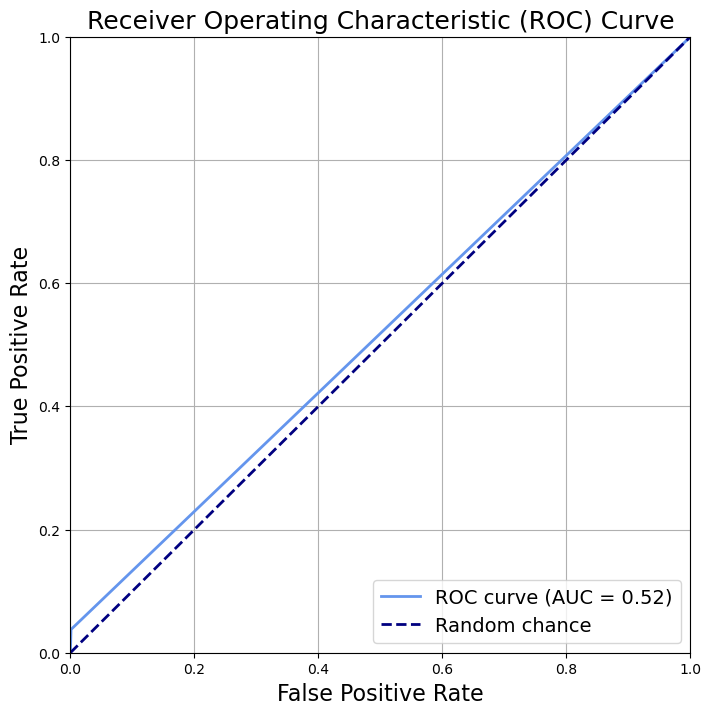

In [44]:
plot_roc_curve(y_val,y_predictions, dpi=100)

In [45]:
y_predictions_proba = forest.predict_proba(X_val)

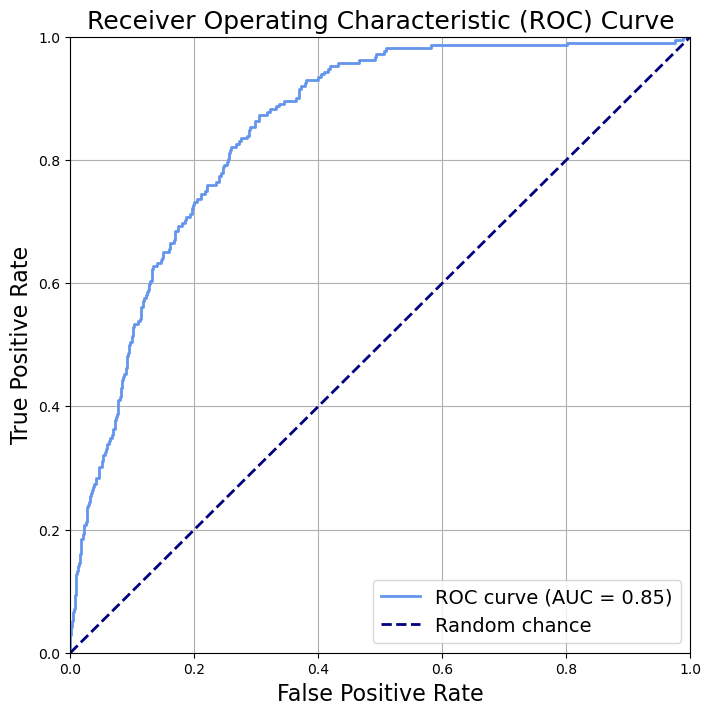

In [47]:
plot_roc_curve(y_val,y_predictions_proba[:,1], dpi=100)

--- 
## 5. Dealing with Imbalanced Data in Classification Tasks

In this section, we will discuss how to handle imbalanced data when working on a classification task, where we have a significantly higher percentage of `False` labels (80-85%) compared to `True` labels (15-20%). We will demonstrate how to address this issue using Python and scikit-learn, focusing on the Random Forest classifier.

### Problem with Imbalanced Data

Imbalanced data can lead to biased models, as they tend to focus more on the majority class, leading to poor performance on the minority class. In our case, a model trained on this dataset might perform well in predicting the `False` labels but fail to predict the `True` labels accurately.

### Techniques to Address Imbalanced Data

There are several techniques to handle imbalanced data. Some popular ones include:

1. **Resampling**: You can either oversample the minority class, undersample the majority class, or use a combination of both to balance the dataset.
2. **Weighted Loss Function**: Assign higher weights to the minority class when training the model, making the classifier more sensitive to the minority class.
3. **Cost-Sensitive Learning**: Modify the learning algorithm to take misclassification costs into account.
4. **Ensemble Methods**: Use ensemble methods, such as bagging and boosting, to improve the model's performance on the minority class.

In this notebook, we will focus on resampling and using a weighted loss function with a Random Forest classifier.


In [48]:
train_data = X_train.copy()
train_data["lable"] = y_train

In [50]:
majority_class = train_data[train_data.lable == False]

minority_class = train_data[train_data.lable == True]
# oder

mask = train_data.lable == False
minority_class = train_data[mask]
majority_class = train_data[~mask]

In [51]:
from sklearn.utils import resample

In [53]:
minority_class_oversampled = resample(
    minority_class, 
    n_samples=majority_class.shape[0],
    random_state=0,
    replace=True
)

In [54]:
train_data_oversample = pd.concat([majority_class, minority_class_oversampled])

In [55]:
train_data_oversample = train_data_oversample.sample(frac=1) #shuffle data

In [57]:
y_train_oversampled = train_data_oversample['lable']
X_train_oversampled = train_data_oversample.drop('lable', axis=1)

In [58]:
y_train_oversampled.value_counts()

lable
0.0    887
1.0    887
Name: count, dtype: int64

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_train_oversampled, y_train_oversampled, test_size=0.3,
                                                    random_state=10)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                  test_size=0.5, random_state=10)

In [60]:
forest_oversampled = RandomForestClassifier(n_estimators=100,
                                max_depth=5,
                                min_samples_leaf=5,
                                random_state=10)
# train the model
forest_oversampled.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=10)

In [61]:
y_os_predictions = forest_oversampled.predict(X_val)

In [62]:
print(metrics.classification_report(y_val, y_os_predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.83       131
         1.0       0.82      0.88      0.84       136

    accuracy                           0.84       267
   macro avg       0.84      0.83      0.83       267
weighted avg       0.84      0.84      0.83       267



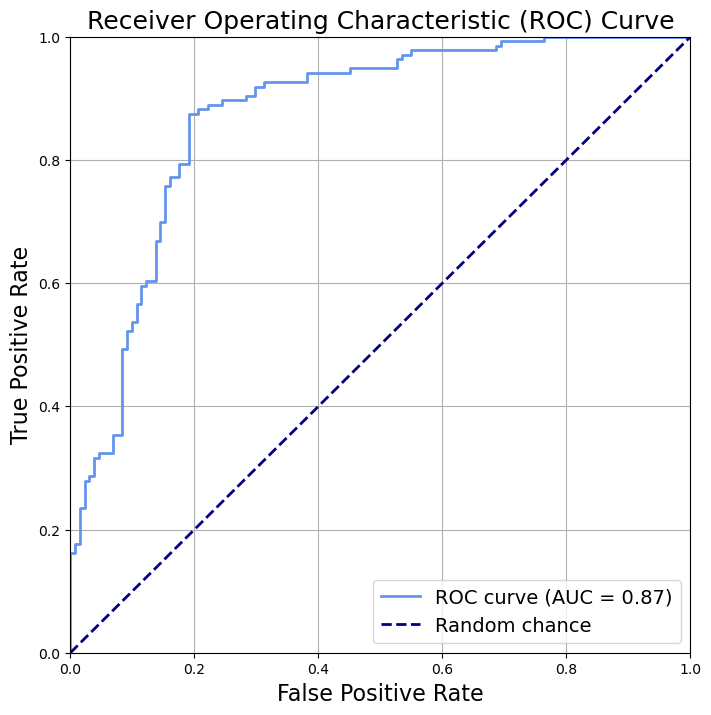

In [63]:
y_os_predictions_proba = forest_oversampled.predict_proba(X_val)
plot_roc_curve(y_val,y_os_predictions_proba[:,1], dpi=100)

Oder so Balancen:

In [64]:
forest_oversampled = RandomForestClassifier(n_estimators=100,
                                max_depth=5,
                                min_samples_leaf=5,
                                random_state=10,
                                class_weight={False:1 , True:10}
                                )